In [3]:
!pwd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/content
Mounted at /content/drive


In [3]:
# @title
%%writefile '/content/drive/MyDrive/Colab Notebooks/rcam/rcam_model.py'

import numpy as np
from dataclasses import dataclass
from typing import Tuple

# ==================== PARAMETERS ====================
@dataclass
class Params:
    """Aircraft parameters container"""
    mass: float = 120000  # kg

    # Aerodynamic parameters
    cbar: float = 6.6
    l: float = 6.6  # mean aerodynamic chord
    lt: float = 24.6  # distance from CoG to AC of tail
    S: float = 260  # wing planform area
    St: float = 64  # tail planform area

    # Center of Gravity location
    xcg: float = 0.23 * 6.6
    ycg: float = 0.0
    zcg: float = 0.10 * 6.6

    # Aerodynamic Center location
    xac: float = 0.12 * 6.6
    yac: float = 0.0
    zac: float = 0.0

    # Engine attachment points
    xapt1: float = 0.0
    yapt1: float = -7.94
    zapt1: float = -1.9

    xapt2: float = 0.0
    yapt2: float = 7.94
    zapt2: float = -1.9

    # Environmental parameters
    rho: float = 1.225  # air density
    g: float = 9.81  # gravitational acceleration


params = Params()

# ==================== INITIALIZATION ====================
x_init = np.array([85, 0, 0, 0, 0, 0, 0, 0.1, 0])  # 9x1 state vector
u_init = np.array([0, -0.1, 0, 0.08, 0.08])  # 5x1 control vector

# Aileron: -0.1502° Elevator: -12.0574° Rudder: -0.3693° Throttle 1: 0.091787 Throttle 2: 0.095224
# u_init = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224])  # 5x1 control vector


# ==================== RCAM DYNAMICS MODEL ====================
def rcam(t: float, X: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    Recursive aircraft model (RCAM) dynamics function.

    Args:
        t: time (not used, included for ODE solver compatibility)
        X: State vector [u, v, w, p, q, r, phi, theta, psi]
        U: Control input [aileron, elevator, rudder, throttle1, throttle2]

    Returns:
        XDot: State derivatives
    """

    # ==================== UNPACK STATE AND CONTROL ====================
    # Control inputs
    u1 = U[0]  # aileron
    u2 = U[1]  # elevator
    u3 = U[2]  # rudder
    u4 = U[3]  # throttle 1
    u5 = U[4]  # throttle 2

    # State variables
    x1 = X[0]  # u (forward velocity)
    x2 = X[1]  # v (lateral velocity)
    x3 = X[2]  # w (vertical velocity)
    x4 = X[3]  # p (roll rate)
    x5 = X[4]  # q (pitch rate)
    x6 = X[5]  # r (yaw rate)
    x7 = X[6]  # phi (roll angle)
    x8 = X[7]  # theta (pitch angle)
    x9 = X[8]  # psi (yaw angle)

    # ==================== AERODYNAMIC CONSTANTS ====================
    depsda = 0.25  # change in downwash wrt alpha
    alpha_L0 = -11.5 * np.pi / 180  # zero lift angle of attack
    n = 5.5  # linear region slope of lift curve
    a3 = -768.5  # coeff of alpha^3
    a2 = 609.2  # coeff of alpha^2
    a1 = -155.2  # coeff of alpha^1
    a0 = 15.212
    alpha_switch = 14.5 * (np.pi / 180)

    # ==================== CONTROL SATURATION ====================
    u1 = np.clip(u1, -25 * np.pi / 180, 10 * np.pi / 180)
    u2 = np.clip(u2, -25 * np.pi / 180, 10 * np.pi / 180)
    u3 = np.clip(u3, -30 * np.pi / 180, 30 * np.pi / 180)
    u4 = np.clip(u4, 0.5 * np.pi / 180, 10 * np.pi / 180)
    u5 = np.clip(u5, 0.5 * np.pi / 180, 10 * np.pi / 180)

    # ==================== INTERMEDIATE VARIABLES ====================
    # Airspeed calculation (accounting for wind)
    Va = np.sqrt(x1**2 + x2**2 + x3**2)

    # Angle of attack and sideslip
    alpha = np.arctan2(x3, x1)
    beta = np.arcsin(np.clip(x2 / Va, -1, 1))  # clip to avoid numerical issues

    # Dynamic pressure
    Q = 0.5 * params.rho * Va**2

    # Velocity and angular velocity vectors in body frame
    V_b = np.array([x1, x2, x3])
    wbe_b = np.array([x4, x5, x6])

    # ==================== AERODYNAMIC FORCE COEFFICIENTS ====================
    # Lift coefficient (wing and body)
    if alpha <= alpha_switch:
        CL_wb = n * (alpha - alpha_L0)
    else:
        CL_wb = a3 * alpha**3 + a2 * alpha**2 + a1 * alpha + a0

    # Tail aerodynamics
    epsilon = depsda * (alpha - alpha_L0)
    alpha_t = alpha - epsilon + u2 + 1.3 * x5 * params.lt / Va
    CL_t = 3.18 * (params.St / params.S) * alpha_t  # FIXED: Added missing * operator

    # Total lift coefficient
    CL = CL_wb + CL_t

    # Drag coefficient (neglecting tail)
    CD = 0.13 + 0.07 * (5.5 * alpha + 0.654)**2

    # Side force coefficient
    CY = -1.6 * beta + 0.24 * u3

    # ==================== DIMENSIONAL AERODYNAMIC FORCES ====================
    # Forces in stability axis frame
    FA_s = np.array([
        -CD * Q * params.S,
        CY * Q * params.S,
        -CL * Q * params.S
    ])

    # Rotation matrix from stability to body frame
    C_bs = np.array([
        [np.cos(alpha), 0, -np.sin(alpha)],
        [0, 1, 0],
        [np.sin(alpha), 0, np.cos(alpha)]
    ])

    # Forces in body frame
    FA_b = C_bs @ FA_s  # FIXED: Case consistency and proper matrix multiplication

    # ==================== AERODYNAMIC MOMENT COEFFICIENTS ====================
    eta11 = -1.4 * beta
    eta21 = -0.59 - (3.2 * (params.St / params.lt) / (params.S * params.l)) * (alpha - epsilon)
    eta31 = (1 - alpha * (180 / (15 * np.pi))) * beta
    eta = np.array([eta11, eta21, eta31])

    # Moment derivatives w.r.t. angular velocities
    dCMdx = (params.l / Va) * np.array([
        [-11, 0, 5],
        [0, -4.03 * (params.St * params.lt) / (params.S * params.l**2), 0],
        [1.7, 0, -11.5]
    ])

    # Moment derivatives w.r.t. control inputs
    dCMdu = np.array([
        [-0.6, 0, 0.22],
        [0, -3.1 * (params.St * params.lt) / (params.S * params.l), 0],
        [0, 0, -0.63]
    ])

    # Moment coefficients about aerodynamic center in body frame
    CMac_b = eta + dCMdx @ wbe_b + dCMdu @ np.array([u1, u2, u3])

    # ==================== AERODYNAMIC MOMENT ====================
    MAac_b = CMac_b * Q * params.S * params.l

    # ==================== TRANSFER MOMENT TO CG ====================
    rcg_b = np.array([params.xcg, params.ycg, params.zcg])
    rac_b = np.array([params.xac, params.yac, params.zac])

    MAcg_b = MAac_b + np.cross(FA_b, rcg_b - rac_b)

    # ==================== ENGINE FORCES ====================
    Tmax = params.mass * params.g
    F1 = u4 * Tmax
    F2 = u5 * Tmax

    # Engine thrust (assumed forward direction only)
    FE1_b = np.array([F1, 0, 0])
    FE2_b = np.array([F2, 0, 0])

    FE_b = FE1_b + FE2_b

    # ==================== ENGINE MOMENTS ====================
    # Moment arms from CG to engine attachment points
    mew1 = np.array([
        params.xcg - params.xapt1,
        params.yapt1 - params.ycg,
        params.zcg - params.zapt1
    ])

    mew2 = np.array([
        params.xcg - params.xapt2,  # FIXED: Was params.xch
        params.yapt2 - params.ycg,
        params.zcg - params.zapt2
    ])

    # Engine moments about CG
    MEcg1_b = np.cross(mew1, FE1_b)
    MEcg2_b = np.cross(mew2, FE2_b)

    MEcg_b = MEcg1_b + MEcg2_b

    # ==================== GRAVITY FORCES ====================
    # Gravity vector in body frame (causes no moment about CoG)
    g_b = np.array([
        -params.g * np.sin(x8),  # FIXED: Changed g to params.g
        params.g * np.cos(x8) * np.sin(x7),
        params.g * np.cos(x8) * np.cos(x7)
    ])

    Fg_b = params.mass * g_b

    # ==================== STATE DERIVATIVES ====================
    # Inertia matrix (constant)
    Ib = np.array([
        [40.07, 0, -2.0923],
        [0, 64, 0],
        [-2.0923, 0, 99.92]
    ]) # * params.mass

    # Inverse inertia matrix
    # invIb = (1 / params.mass) * np.array([
    #     [0.0249836, 0, 0.000523151],
    #     [0, 0.015625, 0],
    #     [0.000523151, 0, 0.0100191]
    # ])

    invIb = np.linalg.inv(Ib)

    # Total forces and linear accelerations
    F_b = Fg_b + FE_b + FA_b
    x1tox3dot = (1 / params.mass) * F_b - np.cross(wbe_b, V_b)

    # Total moments and angular accelerations
    Mcg_b = MAcg_b + MEcg_b
    x4tox6dot = invIb @ (Mcg_b - np.cross(wbe_b, Ib @ wbe_b))

    # Euler angle derivatives
    H_phi = np.array([
        [1, np.sin(x7) * np.tan(x8), np.cos(x7) * np.tan(x8)],
        [0, np.cos(x7), -np.sin(x7)],
        [0, np.sin(x7) / np.cos(x8), np.cos(x7) / np.cos(x8)]
    ])

    x7tox9dot = H_phi @ wbe_b

    # ==================== ASSEMBLE STATE DERIVATIVE VECTOR ====================
    XDot = np.concatenate([x1tox3dot, x4tox6dot, x7tox9dot])  # FIXED: Was x3tox6dor

    return XDot


# ==================== EXAMPLE USAGE ====================
if __name__ == "__main__":
    # Test the dynamics function
    t = 0
    X = x_init.copy()
    U = u_init.copy()

    XDot = rcam(t, X, U)
    print("State derivatives at t=0:")
    print(XDot)
    print(f"\nState shape: {X.shape}")
    print(f"Control shape: {U.shape}")
    print(f"XDot shape: {XDot.shape}")

Overwriting /content/drive/MyDrive/Colab Notebooks/rcam/rcam_model.py


In [5]:
# TESTING EQUILIBRUM CONTROLS

x_equi_test = np.array([85, 0, 0, 0, 0, 0, 0, 0.1, 0])  # 9x1 state vector
# u_init = np.array([0, -0.1, 0, 0.08, 0.08])  # 5x1 control vector

# Aileron: -0.1502° Elevator: -12.0574° Rudder: -0.3693° Throttle 1: 0.091787 Throttle 2: 0.095224
u_equi_test = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224])  # 5x1 control vector

XDot_equi_test = rcam(0, x_equi_test, u_equi_test)
print("State derivatives at t=0:")
print(XDot_equi_test)
print(f"\nState shape: {x_equi_test.shape}")
print(f"Control shape: {u_equi_test.shape}")
print(f"XDot shape: {XDot_equi_test.shape}")

State derivatives at t=0:
[ -0.6783221   -0.01483329   1.13221127   0.01484408 -10.68499752
   0.05199864   0.           0.           0.        ]

State shape: (9,)
Control shape: (5,)
XDot shape: (9,)


In [4]:
# @title
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


import sys
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/rcam/"

if PROJECT_ROOT not in sys.path:
  sys.path.insert(0, PROJECT_ROOT)

print("Project ready: ", PROJECT_ROOT)


"""
RCAM Aircraft Dynamics Simulator
Example showing how to simulate the aircraft model over time
"""

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

import importlib
import rcam_model
importlib.reload(rcam_model)
from rcam_model import rcam, params, x_init, u_init

Mounted at /content/drive
Project ready:  /content/drive/MyDrive/Colab Notebooks/rcam/


In [5]:
# @title
# ==================== CONTROL INPUT PROFILE ====================
def get_control_input(t: float) -> np.ndarray:
    """
    Define control inputs as a function of time.
    This is a simple example; modify as needed for your scenario.
    """
    u = u_init.copy()
    #u = np.array([-0.00262148, -0.210411, -0.006446, 0.091787, 0.095224]) # equilibrum controls
    if t < 2 or t > 4:
        u[1] = 0.003  # aileron command
        #u[2] = 0
    else:
        u[1] = 0

    # # Example: Introduce a step in elevator at t=10s
    # if t > 10:
    #     u[1] = -0.05  # elevator command

    return u

In [6]:
# ==================== ODE WRAPPER ====================
def rcam_wrapper(X: np.ndarray, t: float) -> np.ndarray:
    """
    Wrapper for ODE solver that provides time-varying control inputs.
    """
    U = get_control_input(t)
    return rcam(t, X, U)

In [9]:
# ==================== SIMULATION CONFIGURATION ====================
t_start = 0.0
t_end = 50.0
dt = 0.01
teval= np.arange(t_start, t_end, dt)
num_steps = len(teval)

# ==================== SIMULATION ====================
print("Starting RCAM simulation...")
print(f"Simulation duration: {t_start} to {t_end} seconds")
print(f"Number of steps: {num_steps}")

# Run simulation using scipy's odeint
# X_trajectory = odeint(rcam_wrapper, x_init, time)

sol = solve_ivp(
    lambda t, x: rcam(t, x, get_control_input(t)),
    [t_start, t_end],
    x_init,
    method="Radau",
    #max_step=dt,
    #t_eval=teval,
    rtol=1e-6,
    atol=1e-9
)

time = sol.t
X_trajectory = sol.y.T

print("Success:", sol.success)
print("Message:", sol.message)
print("Final time reached:", sol.t[-1])
print("Expected final time:", t_end)


print(f"Simulation complete!")
print(f"Trajectory shape: {X_trajectory}")
print(f"Trajectory shape: {X_trajectory.shape} {time.shape}")

# ==================== EXTRACT STATE COMPONENTS ====================
u_vel = X_trajectory[:, 0]  # forward velocity
v_vel = X_trajectory[:, 1]  # lateral velocity
w_vel = X_trajectory[:, 2]  # vertical velocity
p_rate = X_trajectory[:, 3]  # roll rate
q_rate = X_trajectory[:, 4]  # pitch rate
r_rate = X_trajectory[:, 5]  # yaw rate
phi = X_trajectory[:, 6]    # roll angle
theta = X_trajectory[:, 7]  # pitch angle
psi = X_trajectory[:, 8]    # yaw angle

# Calculate derived quantities
airspeed = np.sqrt(u_vel**2 + v_vel**2 + w_vel**2)
phi_deg = np.degrees(phi)
theta_deg = np.degrees(theta)
psi_deg = np.degrees(psi)

Starting RCAM simulation...
Simulation duration: 0.0 to 50.0 seconds
Number of steps: 5000
Success: False
Message: Required step size is less than spacing between numbers.
Final time reached: 0.18561654529296828
Expected final time: 50.0
Simulation complete!
Trajectory shape: [[ 8.50000000e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e-01  0.00000000e+00]
 [ 8.50000000e+01  0.00000000e+00 -9.83078705e-09 ...  0.00000000e+00
   1.00000000e-01  0.00000000e+00]
 [ 8.49999998e+01  0.00000000e+00 -2.26630745e-07 ...  0.00000000e+00
   9.99999984e-02  0.00000000e+00]
 ...
 [-8.30144584e+01  0.00000000e+00 -1.01114199e-10 ...  0.00000000e+00
  -3.23808797e+00  0.00000000e+00]
 [-8.30144584e+01  0.00000000e+00 -2.93709343e-11 ...  0.00000000e+00
  -3.23808797e+00  0.00000000e+00]
 [-8.30144584e+01  0.00000000e+00 -6.91517202e-12 ...  0.00000000e+00
  -3.23808797e+00  0.00000000e+00]]
Trajectory shape: (165, 9) (165,)


In [10]:
# ==================== PRINT KEY RESULTS ====================
print("\n" + "="*60)
print("SIMULATION RESULTS")
print("="*60)
print(f"Initial State: {x_init}")
print(f"Initial Control: {u_init}")
print(f"\nFinal State: {X_trajectory[-1]}")
print(f"\nAirspeed Range: {airspeed.min():.2f} to {airspeed.max():.2f} m/s")
print(f"Roll Angle Range: {phi_deg.min():.2f}° to {phi_deg.max():.2f}°")
print(f"Pitch Angle Range: {theta_deg.min():.2f}° to {theta_deg.max():.2f}°")
print(f"Yaw Angle Range: {psi_deg.min():.2f}° to {psi_deg.max():.2f}°")


SIMULATION RESULTS
Initial State: [85.   0.   0.   0.   0.   0.   0.   0.1  0. ]
Initial Control: [ 0.   -0.1   0.    0.08  0.08]

Final State: [-8.30144584e+01  0.00000000e+00 -6.91517202e-12  0.00000000e+00
 -6.33688425e+02  0.00000000e+00  0.00000000e+00 -3.23808797e+00
  0.00000000e+00]

Airspeed Range: 83.01 to 85.00 m/s
Roll Angle Range: 0.00° to 0.00°
Pitch Angle Range: -185.53° to 5.73°
Yaw Angle Range: 0.00° to 0.00°


Plot saved to rcam_simulation.png


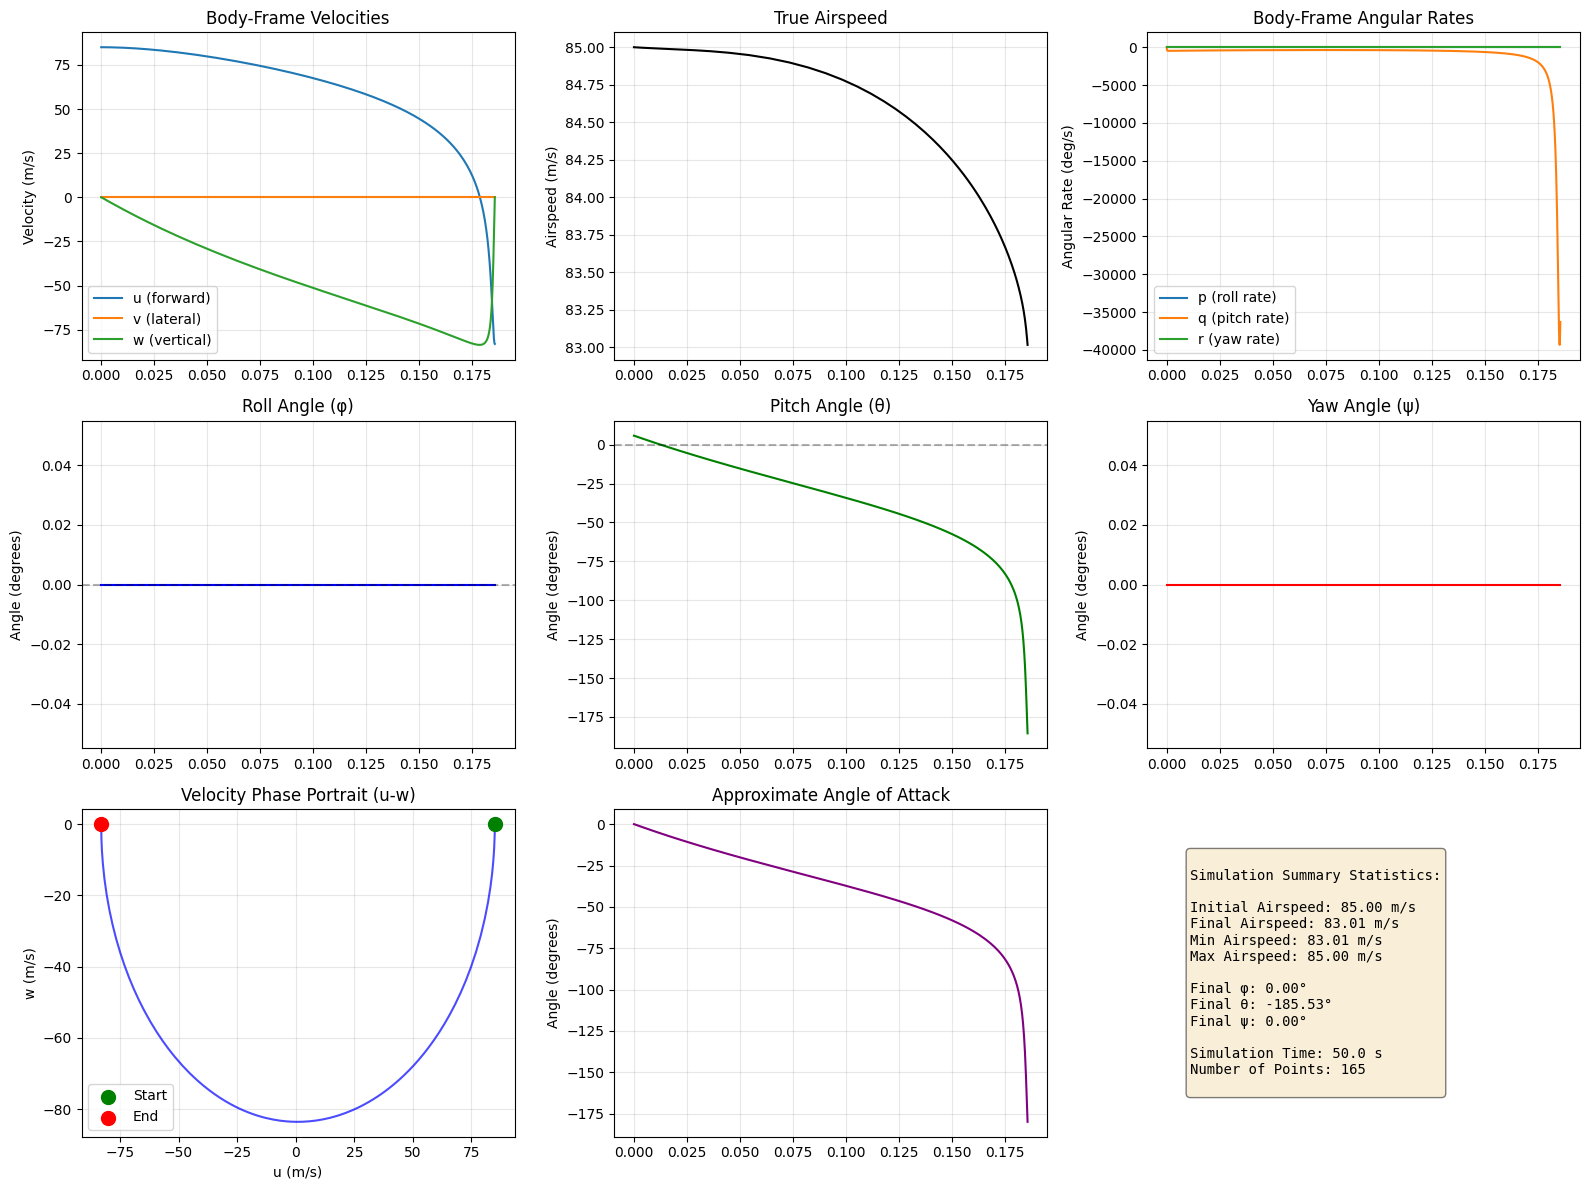

Trajectory saved to rcam_trajectory.csv


In [11]:
# ==================== PLOTTING ====================
fig = plt.figure(figsize=(16, 12))

# Velocities
ax1 = plt.subplot(3, 3, 1)
ax1.plot(time, u_vel, label='u (forward)', linewidth=1.5)
ax1.plot(time, v_vel, label='v (lateral)', linewidth=1.5)
ax1.plot(time, w_vel, label='w (vertical)', linewidth=1.5)
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Body-Frame Velocities')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Airspeed
ax2 = plt.subplot(3, 3, 2)
ax2.plot(time, airspeed, 'k-', linewidth=1.5)
ax2.set_ylabel('Airspeed (m/s)')
ax2.set_title('True Airspeed')
ax2.grid(True, alpha=0.3)

# Angular rates
ax3 = plt.subplot(3, 3, 3)
ax3.plot(time, np.degrees(p_rate), label='p (roll rate)', linewidth=1.5)
ax3.plot(time, np.degrees(q_rate), label='q (pitch rate)', linewidth=1.5)
ax3.plot(time, np.degrees(r_rate), label='r (yaw rate)', linewidth=1.5)
ax3.set_ylabel('Angular Rate (deg/s)')
ax3.set_title('Body-Frame Angular Rates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Roll angle
ax4 = plt.subplot(3, 3, 4)
ax4.plot(time, phi_deg, 'b-', linewidth=1.5)
ax4.set_ylabel('Angle (degrees)')
ax4.set_title('Roll Angle (φ)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Pitch angle
ax5 = plt.subplot(3, 3, 5)
ax5.plot(time, theta_deg, 'g-', linewidth=1.5)
ax5.set_ylabel('Angle (degrees)')
ax5.set_title('Pitch Angle (θ)')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Yaw angle
ax6 = plt.subplot(3, 3, 6)
ax6.plot(time, psi_deg, 'r-', linewidth=1.5)
ax6.set_ylabel('Angle (degrees)')
ax6.set_title('Yaw Angle (ψ)')
ax6.grid(True, alpha=0.3)

# Phase portrait: u vs w
ax7 = plt.subplot(3, 3, 7)
ax7.plot(u_vel, w_vel, 'b-', linewidth=1.5, alpha=0.7)
ax7.scatter([u_vel[0]], [w_vel[0]], color='g', s=100, label='Start', zorder=5)
ax7.scatter([u_vel[-1]], [w_vel[-1]], color='r', s=100, label='End', zorder=5)
ax7.set_xlabel('u (m/s)')
ax7.set_ylabel('w (m/s)')
ax7.set_title('Velocity Phase Portrait (u-w)')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Angle of attack approximation
alpha_approx = np.arctan2(w_vel, u_vel)
ax8 = plt.subplot(3, 3, 8)
ax8.plot(time, np.degrees(alpha_approx), 'purple', linewidth=1.5)
ax8.set_ylabel('Angle (degrees)')
ax8.set_title('Approximate Angle of Attack')
ax8.grid(True, alpha=0.3)

# Summary statistics
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
stats_text = f"""
Simulation Summary Statistics:

Initial Airspeed: {airspeed[0]:.2f} m/s
Final Airspeed: {airspeed[-1]:.2f} m/s
Min Airspeed: {airspeed.min():.2f} m/s
Max Airspeed: {airspeed.max():.2f} m/s

Final φ: {phi_deg[-1]:.2f}°
Final θ: {theta_deg[-1]:.2f}°
Final ψ: {psi_deg[-1]:.2f}°

Simulation Time: {t_end - t_start:.1f} s
Number of Points: {len(time)}
"""
ax9.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/rcam/plot"

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/rcam_simulation.png', dpi=150, bbox_inches='tight')
print("Plot saved to rcam_simulation.png")
plt.show()

# ==================== DATA EXPORT ====================
# Save trajectory to CSV for further analysis
data = np.column_stack([
    time, u_vel, v_vel, w_vel, p_rate, q_rate, r_rate,
    phi_deg, theta_deg, psi_deg, airspeed, np.degrees(alpha_approx)
])

header = 'time,u,v,w,p,q,r,phi_deg,theta_deg,psi_deg,airspeed,alpha_deg'
np.savetxt(f'{SAVE_DIR}/rcam_trajectory.csv', data, delimiter=',', header=header, comments='')
print("Trajectory saved to rcam_trajectory.csv")

In [7]:
# @title
%%writefile '/content/drive/MyDrive/Colab Notebooks/rcam/equilibrum.py'

"""
RCAM Straight-Level Flight Equilibrium Finder
Finds control inputs (U) that achieve straight-level flight conditions
Uses scipy.optimize.minimize with trust-constr method
"""

import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as plt
from rcam_model import rcam, params, x_init, u_init

# ==================== EQUILIBRIUM COST FUNCTION ====================

def equilibrium_cost(U_opt: np.ndarray, target_airspeed: float = 85.0) -> float:
    """
    Cost function for equilibrium: minimize state derivatives.

    For straight-level flight, we want:
    - Pitch rate (q) ≈ 0
    - Roll rate (p) ≈ 0
    - Yaw rate (r) ≈ 0
    - Pitch angle (theta) ≈ 0 (level flight)
    - Roll angle (phi) ≈ 0 (wings level)
    - Vertical velocity (w) ≈ 0

    Args:
        U_opt: Control inputs [aileron, elevator, rudder, throttle1, throttle2]
        target_airspeed: Desired airspeed in m/s

    Returns:
        Cost (float): Sum of squared state derivatives (penalizing motion)
    """

    # State for equilibrium: cruising at target airspeed, level, wings level
    X_eq = np.array([
        target_airspeed,  # u: forward velocity
        0.0,              # v: lateral velocity
        0.0,              # w: vertical velocity
        0.0,              # p: roll rate
        0.0,              # q: pitch rate
        0.0,              # r: yaw rate
        0.0,              # phi: roll angle
        0.0,              # theta: pitch angle
        0.0               # psi: yaw angle (doesn't matter for straight flight)
    ])

    # Calculate state derivatives at this condition
    t = 0
    X_dot = rcam(t, X_eq, U_opt)

    # Cost: weighted sum of squared derivatives
    # Prioritize zeroing angular rates and vertical velocity
    weights = np.array([
        10.0,   # u_dot: maintain airspeed
        50.0,   # v_dot: minimize lateral velocity change
        50.0,   # w_dot: minimize vertical velocity change
        100.0,  # p_dot: minimize roll rate change
        100.0,  # q_dot: minimize pitch rate change
        100.0,  # r_dot: minimize yaw rate change
        10.0,   # phi_dot: (should be zero naturally from p=0)
        10.0,   # theta_dot: (should be zero naturally from q=0)
        1.0     # psi_dot: (doesn't matter for straight flight)
    ])

    cost = np.sum(weights * X_dot**2)
    return cost


def equilibrium_cost_with_state_error(U_and_state: np.ndarray, target_airspeed: float = 85.0) -> float:
    """
    Alternative cost function that also penalizes deviations from desired state.
    Allows finding equilibrium at specific flight conditions.

    Args:
        U_and_state: [U (8D), X (9D)] concatenated vector
        target_airspeed: Desired airspeed

    Returns:
        Cost combining state error and derivatives
    """
    U_opt = U_and_state[:8]
    X_opt = U_and_state[8:17]  # Only first 9 states (not 12)

    # Desired state: straight-level flight at target airspeed
    X_desired = np.array([
        target_airspeed,  # u
        0.0,              # v
        0.0,              # w
        0.0,              # p
        0.0,              # q
        0.0,              # r
        0.0,              # phi
        0.0,              # theta
        0.0               # psi
    ])

    # State error cost
    state_weights = np.array([5.0, 50.0, 50.0, 50.0, 50.0, 50.0, 20.0, 20.0, 1.0])
    state_error_cost = np.sum(state_weights * (X_opt - X_desired)**2)

    # Derivative cost
    X_dot = rcam(0, X_opt, U_opt)
    derivative_weights = np.array([10.0, 50.0, 50.0, 100.0, 100.0, 100.0, 10.0, 10.0, 1.0])
    derivative_cost = np.sum(derivative_weights * X_dot**2)

    total_cost = state_error_cost + derivative_cost
    return total_cost


# ==================== CONSTRAINT FUNCTIONS ====================

def state_derivative_constraint(U_opt: np.ndarray, target_airspeed: float = 85.0) -> np.ndarray:
    """
    Constraint: State derivatives should be zero for equilibrium.
    This is used as a nonlinear constraint in the optimization.

    Args:
        U_opt: Control inputs
        target_airspeed: Desired airspeed

    Returns:
        Array of state derivatives (should be ≈ 0)
    """
    X_eq = np.array([target_airspeed, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    X_dot = rcam(0, X_eq, U_opt)
    return X_dot


# ==================== OPTIMIZATION SETUP ====================

def find_equilibrium(target_airspeed: float = 85.0,
                     method: str = 'cost_only',
                     verbose: bool = True) -> dict:
    """
    Find straight-level flight equilibrium conditions.

    Args:
        target_airspeed: Desired airspeed (m/s)
        method: 'cost_only' or 'with_constraints'
        verbose: Print optimization details

    Returns:
        Dictionary with optimization results and equilibrium control/state
    """

    print(f"\n{'='*70}")
    print(f"RCAM EQUILIBRIUM FINDER - Straight-Level Flight")
    print(f"{'='*70}")
    print(f"Target Airspeed: {target_airspeed} m/s")
    print(f"Method: {method}")

    # Initial guess: use provided initial controls
    U0 = u_init.copy()

    # Bounds for control inputs (in radians and normalized thrust)
    bounds = [
        (-25*np.pi/180, 10*np.pi/180),   # u1: aileron
        (-25*np.pi/180, 10*np.pi/180),   # u2: elevator
        (-30*np.pi/180, 30*np.pi/180),   # u3: rudder
        (0.5*np.pi/180, 10*np.pi/180),   # u4: throttle 1
        (0.5*np.pi/180, 10*np.pi/180),   # u5: throttle 2
    ]

    # ==================== METHOD 1: Cost-only Minimization ====================
    if method == 'cost_only':
        print("\nUsing cost function minimization (derivatives ≈ 0)...")

        options = {
            'maxiter': 1000,
            'verbose': 1 if verbose else 0,
            'gtol': 1e-6,
        }

        result = minimize(
            equilibrium_cost,
            U0,
            args=(target_airspeed,),
            method='trust-constr',
            bounds=bounds,
            options=options
        )

    # ==================== METHOD 2: With Constraints ====================
    elif method == 'with_constraints':
        print("\nUsing constrained optimization (X_dot = 0 as constraint)...")

        # Nonlinear constraint: state derivatives should be zero
        constraint = NonlinearConstraint(
            lambda U: state_derivative_constraint(U, target_airspeed),
            np.zeros(9),  # lower bound
            np.zeros(9)   # upper bound
        )

        options = {
            'maxiter': 1000,
            'verbose': 1 if verbose else 0,
        }

        result = minimize(
            equilibrium_cost,
            U0,
            args=(target_airspeed,),
            method='trust-constr',
            bounds=bounds,
            constraints=constraint,
            options=options
        )

    else:
        raise ValueError(f"Unknown method: {method}")

    # ==================== EXTRACT AND VERIFY RESULTS ====================

    U_opt = result.x

    # Calculate equilibrium state and derivatives
    X_eq = np.array([target_airspeed, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    X_dot_eq = rcam(0, X_eq, U_opt)

    # Calculate actual airspeed with wind
    actual_airspeed = np.sqrt(
        X_eq[0]**2 +
        X_eq[1]**2 +
        X_eq[2]**2
    )

    # Package results
    results = {
        'success': result.success,
        'message': result.message,
        'nit': result.nit,
        'nfev': result.nfev,
        'cost': result.fun,
        'U_optimal': U_opt,
        'X_equilibrium': X_eq,
        'X_dot_equilibrium': X_dot_eq,
        'max_derivative': np.max(np.abs(X_dot_eq)),
        'target_airspeed': target_airspeed,
        'actual_airspeed': actual_airspeed,
    }

    return results


def find_equilibrium_multipoint(airspeed_range: np.ndarray = None,
                                method: str = 'cost_only') -> dict:
    """
    Find equilibrium conditions across a range of airspeeds.

    Args:
        airspeed_range: Array of target airspeeds to optimize
        method: Optimization method

    Returns:
        Dictionary with results for each airspeed
    """
    if airspeed_range is None:
        airspeed_range = np.linspace(50, 120, 15)

    results_dict = {}

    print(f"\n{'='*70}")
    print(f"MULTI-POINT EQUILIBRIUM ANALYSIS")
    print(f"{'='*70}")
    print(f"Analyzing {len(airspeed_range)} airspeeds from {airspeed_range[0]:.1f} to {airspeed_range[-1]:.1f} m/s\n")

    for i, Va in enumerate(airspeed_range):
        print(f"[{i+1}/{len(airspeed_range)}] Va = {Va:.1f} m/s...", end='', flush=True)

        result = find_equilibrium(target_airspeed=Va, method=method, verbose=False)
        results_dict[Va] = result

        status = "✓" if result['success'] else "✗"
        print(f" {status} (cost: {result['cost']:.6f}, max_deriv: {result['max_derivative']:.6e})")

    return results_dict


# ==================== PLOTTING UTILITIES ====================

def plot_equilibrium_results(result: dict, figsize: tuple = (14, 10)):
    """
    Plot the equilibrium condition results.

    Args:
        result: Dictionary from find_equilibrium()
        figsize: Figure size
    """

    U_opt = result['U_optimal']
    X_dot_eq = result['X_equilibrium']
    cost = result['cost']

    fig = plt.figure(figsize=figsize)

    # Control inputs
    ax1 = plt.subplot(2, 3, 1)
    labels = ['Aileron', 'Elevator', 'Rudder', 'Throttle 1', 'Throttle 2']
    colors = ['b', 'g', 'r', 'orange', 'purple', 'brown', 'pink', 'gray']

    x_pos = np.arange(len(labels))
    heights = np.concatenate([np.degrees(U_opt[:3]),  [U_opt[3]*180/np.pi, U_opt[4]*180/np.pi]])
    ax1.bar(x_pos[:5], heights,
            color=colors[:5], alpha=0.7)
    ax1.set_xticks(x_pos[:5])
    ax1.set_xticklabels(labels[:5], rotation=45, ha='right')
    ax1.set_ylabel('Control Input (deg or normalized)')
    ax1.set_title('Optimal Control Inputs (First 5)')
    ax1.grid(True, alpha=0.3)


    # State derivatives
    ax3 = plt.subplot(2, 3, 2)
    state_labels = ['u', 'v', 'w', 'p', 'q', 'r', 'φ', 'θ', 'ψ']
    colors_state = ['b', 'g', 'r', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    ax3.bar(np.arange(len(state_labels)), X_dot_eq, color=colors_state, alpha=0.7)
    ax3.set_xticks(np.arange(len(state_labels)))
    ax3.set_xticklabels(state_labels)
    ax3.set_ylabel('State Derivative')
    ax3.set_title('State Derivatives at Equilibrium\n(Should be ≈ 0)')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='k', linestyle='--', linewidth=1)

    # Optimization metrics
    ax4 = plt.subplot(2, 3, 3)
    ax4.axis('off')
    metrics_text = f"""
OPTIMIZATION RESULTS

Target Airspeed: {result['target_airspeed']:.2f} m/s
Actual Airspeed: {result['actual_airspeed']:.2f} m/s

Optimization Status: {'SUCCESS' if result['success'] else 'FAILED'}
Cost Function: {result['cost']:.6e}
Max Derivative: {result['max_derivative']:.6e}
Iterations: {result['nit']}
Function Evaluations: {result['nfev']}

Message: {result['message']}
"""
    ax4.text(0.1, 0.5, metrics_text, fontfamily='monospace', fontsize=9,
             verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Control saturation check
    ax5 = plt.subplot(2, 3, 4)
    bounds_lower = [-25, -25, -30, 0.5, 0.5]
    bounds_upper = [10, 10, 30, 10, 10]

    U_plot = np.concatenate([
        np.degrees(U_opt[:3]),
        U_opt[3:5],
    ])
    bounds_lower_plot = np.array(bounds_lower[:3] + bounds_lower[3:])
    bounds_upper_plot = np.array(bounds_upper[:3] + bounds_upper[3:])

    x_pos = np.arange(len(U_plot))
    ax5.barh(x_pos, bounds_upper_plot - bounds_lower_plot, left=bounds_lower_plot,
             alpha=0.3, color='gray', label='Constraint Range')
    ax5.scatter(U_plot, x_pos, color='red', s=100, zorder=5, label='Optimal Value')
    ax5.set_yticks(x_pos)
    ax5.set_yticklabels(labels)
    ax5.set_xlabel('Control Value (deg or normalized)')
    ax5.set_title('Control Saturation Check')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    return fig


def plot_multipoint_analysis(results_dict: dict):
    """
    Plot equilibrium conditions across multiple airspeeds.

    Args:
        results_dict: Dictionary from find_equilibrium_multipoint()
    """

    airspeeds = sorted(results_dict.keys())

    # Extract data
    elevator_commands = []
    throttle_commands = []
    costs = []
    max_derivatives = []

    for Va in airspeeds:
        result = results_dict[Va]
        elevator_commands.append(np.degrees(result['U_optimal'][1]))
        throttle_avg = np.mean(np.degrees(result['U_optimal'][3:5]))
        throttle_commands.append(throttle_avg)
        costs.append(result['cost'])
        max_derivatives.append(result['max_derivative'])

    fig = plt.figure(figsize=(14, 10))

    # Elevator command
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(airspeeds, elevator_commands, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Airspeed (m/s)')
    ax1.set_ylabel('Elevator Command (deg)')
    ax1.set_title('Equilibrium Elevator Command vs Airspeed')
    ax1.grid(True, alpha=0.3)

    # Throttle command
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(airspeeds, throttle_commands, 'g-o', linewidth=2, markersize=6)
    ax2.set_xlabel('Airspeed (m/s)')
    ax2.set_ylabel('Throttle Command (deg equivalent)')
    ax2.set_title('Equilibrium Throttle Command vs Airspeed')
    ax2.grid(True, alpha=0.3)

    # Cost function
    ax3 = plt.subplot(2, 2, 3)
    ax3.semilogy(airspeeds, costs, 'r-o', linewidth=2, markersize=6)
    ax3.set_xlabel('Airspeed (m/s)')
    ax3.set_ylabel('Cost Function (log scale)')
    ax3.set_title('Optimization Cost vs Airspeed')
    ax3.grid(True, alpha=0.3)

    # Max derivative
    ax4 = plt.subplot(2, 2, 4)
    ax4.semilogy(airspeeds, max_derivatives, 'purple', marker='o', linewidth=2, markersize=6)
    ax4.set_xlabel('Airspeed (m/s)')
    ax4.set_ylabel('Max |X_dot| (log scale)')
    ax4.set_title('Maximum State Derivative vs Airspeed')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":

    # Example 1: Single-point equilibrium at 85 m/s
    print("\n" + "="*70)
    print("EXAMPLE 1: Single-Point Equilibrium (85 m/s)")
    print("="*70)

    result_85 = find_equilibrium(target_airspeed=85.0, method='cost_only', verbose=True)

    print(f"\nOptimization Results:")
    print(f"  Success: {result_85['success']}")
    print(f"  Cost: {result_85['cost']:.6e}")
    print(f"  Max State Derivative: {result_85['max_derivative']:.6e}")
    print(f"\nOptimal Control Inputs:")
    print(f"  Aileron: {np.degrees(result_85['U_optimal'][0]):.4f}°")
    print(f"  Elevator: {np.degrees(result_85['U_optimal'][1]):.4f}°")
    print(f"  Rudder: {np.degrees(result_85['U_optimal'][2]):.4f}°")
    print(f"  Throttle 1: {result_85['U_optimal'][3]:.6f}")
    print(f"  Throttle 2: {result_85['U_optimal'][4]:.6f}")


    # Plot single-point result
    fig1 = plot_equilibrium_results(result_85)
    fig1.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_single_point.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_single_point.png")

    # Example 2: Multi-point analysis
    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Point Equilibrium Analysis")
    print("="*70)

    airspeed_range = np.linspace(50, 120, 15)
    results_multipoint = find_equilibrium_multipoint(airspeed_range=airspeed_range, method='cost_only')

    # Plot multi-point analysis
    fig2 = plot_multipoint_analysis(results_multipoint)
    fig2.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_multipoint.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_multipoint.png")

    # Example 3: Find equilibrium at different airspeeds with better convergence
    print("\n" + "="*70)
    print("EXAMPLE 3: Additional Equilibrium Points")
    print("="*70)

    test_airspeeds = [70, 90, 110]
    for Va in test_airspeeds:
        result = find_equilibrium(target_airspeed=Va, method='cost_only', verbose=False)
        print(f"\nAirspeed {Va} m/s:")
        print(f"  Elevator: {np.degrees(result['U_optimal'][1]):.4f}°")
        print(f"  Throttle Avg: {np.mean(result['U_optimal'][3:5]):.6f}")
        print(f"  Cost: {result['cost']:.6e}")

    # Export equilibrium controls to CSV
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)

    export_data = np.array([[Va,
                             np.degrees(results_multipoint[Va]['U_optimal'][1]),
                             np.mean(results_multipoint[Va]['U_optimal'][3:5]),
                             results_multipoint[Va]['cost'],
                             results_multipoint[Va]['max_derivative']]
                            for Va in sorted(results_multipoint.keys())])

    header = 'airspeed_ms,elevator_deg,throttle_avg,cost,max_derivative'
    np.savetxt('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_commands.csv', export_data,
                delimiter=',', header=header, comments='', fmt='%.6f')
    print("Equilibrium commands saved to equilibrium_commands.csv")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)

Overwriting /content/drive/MyDrive/Colab Notebooks/rcam/equilibrum.py


Mounted at /content/drive

EXAMPLE 1: Single-Point Equilibrium (85 m/s)

RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 85.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
`xtol` termination condition is satisfied.
Number of iterations: 211, function evaluations: 2082, CG iterations: 815, optimality: 4.19e+03, constraint violation: 0.00e+00, execution time:  1.8 s.

Optimization Results:
  Success: True
  Cost: 7.070889e+01
  Max State Derivative: 1.181451e+00

Optimal Control Inputs:
  Optimal Control: [-0.0026213  -0.21044175 -0.00644581  0.0917867   0.09522417]
  Optimal X: [85.  0.  0.  0.  0.  0.  0.  0.  0.]
  Optimal Xdot: [ 3.01042459e-01 -1.48328548e-02  1.18145116e+00  2.38452052e-04
 -9.56250158e-04 -1.35120139e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
  Aileron: -0.1502°
  Elevator: -12.0574°
  Rudder: -0.3693°
  Throttle 1: 0.091787
  Throttle 2: 0.095224

Plot saved to equilibrium_single_point.png

EXAMPLE 2: Mul

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


 ✓ (cost: 2245.926144, max_deriv: 6.658746e+00)
[2/15] Va = 55.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 55.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1851.738647, max_deriv: 6.042105e+00)
[3/15] Va = 60.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 60.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1472.560126, max_deriv: 5.399098e+00)
[4/15] Va = 65.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 65.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 1105.030706, max_deriv: 4.680460e+00)
[5/15] Va = 70.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Target Airspeed: 70.0 m/s
Method: cost_only

Using cost function minimization (derivatives ≈ 0)...
 ✓ (cost: 764.660262, max_deriv: 3.892795e+00)
[6/15] Va = 75.0 m/s...
RCAM EQUILIBRIUM FINDER - Straight-Level Flight
Targe

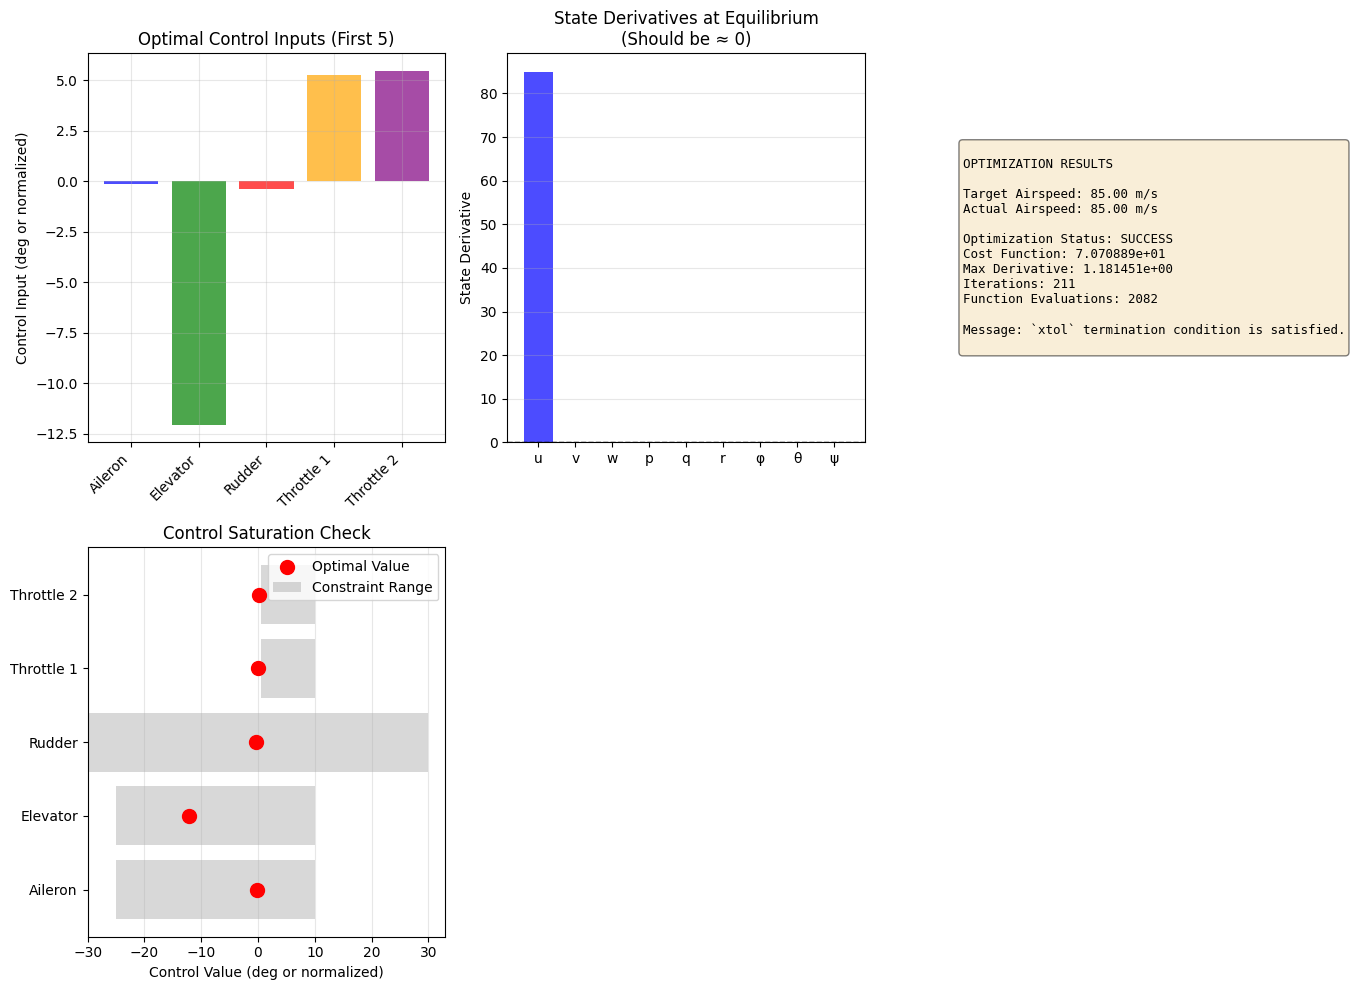

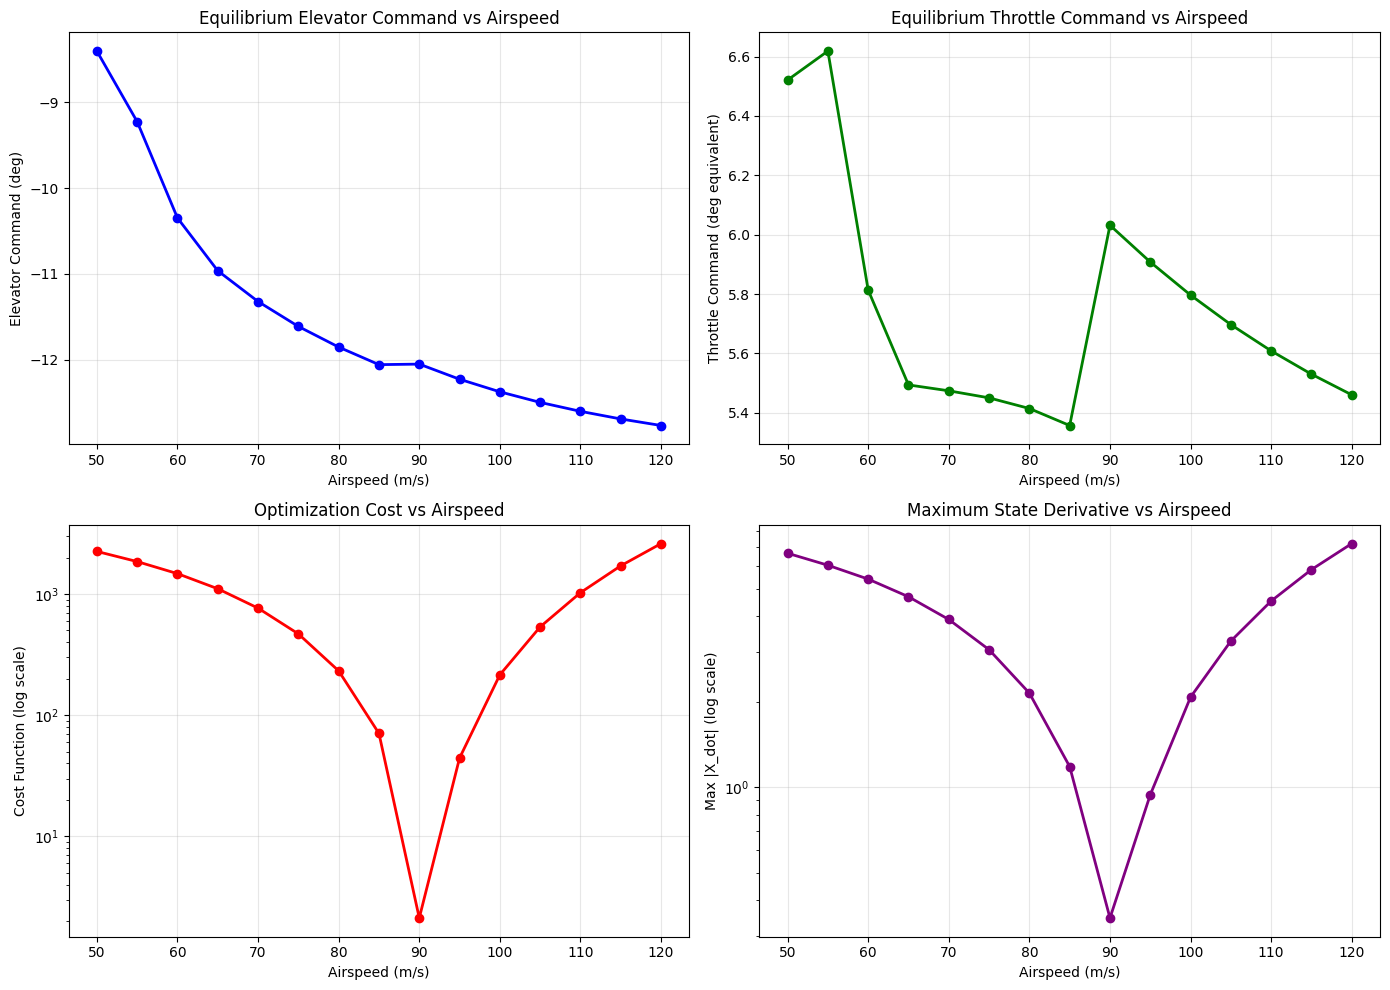

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/rcam/"

if PROJECT_ROOT not in sys.path:
  sys.path.insert(0, PROJECT_ROOT)


import equilibrum
import importlib;
importlib.reload(equilibrum)
from equilibrum import *

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":

    # Example 1: Single-point equilibrium at 85 m/s
    print("\n" + "="*70)
    print("EXAMPLE 1: Single-Point Equilibrium (85 m/s)")
    print("="*70)

    result_85 = find_equilibrium(target_airspeed=85.0, method='cost_only', verbose=True)

    print(f"\nOptimization Results:")
    print(f"  Success: {result_85['success']}")
    print(f"  Cost: {result_85['cost']:.6e}")
    print(f"  Max State Derivative: {result_85['max_derivative']:.6e}")
    print(f"\nOptimal Control Inputs:")
    print(f"  Optimal Control: {result_85['U_optimal']}")
    print(f"  Optimal X: {result_85['X_equilibrium']}")
    print(f"  Optimal Xdot: {result_85['X_dot_equilibrium']}")
    print(f"  Aileron: {np.degrees(result_85['U_optimal'][0]):.4f}°")
    print(f"  Elevator: {np.degrees(result_85['U_optimal'][1]):.4f}°")
    print(f"  Rudder: {np.degrees(result_85['U_optimal'][2]):.4f}°")
    print(f"  Throttle 1: {result_85['U_optimal'][3]:.6f}")
    print(f"  Throttle 2: {result_85['U_optimal'][4]:.6f}")


    # Plot single-point result
    fig1 = plot_equilibrium_results(result_85)
    fig1.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_single_point.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_single_point.png")

    # Example 2: Multi-point analysis
    print("\n" + "="*70)
    print("EXAMPLE 2: Multi-Point Equilibrium Analysis")
    print("="*70)

    airspeed_range = np.linspace(50, 120, 15)
    results_multipoint = find_equilibrium_multipoint(airspeed_range=airspeed_range, method='cost_only')

    # Plot multi-point analysis
    fig2 = plot_multipoint_analysis(results_multipoint)
    fig2.savefig('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_multipoint.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved to equilibrium_multipoint.png")

    # Example 3: Find equilibrium at different airspeeds with better convergence
    print("\n" + "="*70)
    print("EXAMPLE 3: Additional Equilibrium Points")
    print("="*70)

    test_airspeeds = [70, 90, 110]
    for Va in test_airspeeds:
        result = find_equilibrium(target_airspeed=Va, method='cost_only', verbose=False)
        print(f"\nAirspeed {Va} m/s:")
        print(f"  Elevator: {np.degrees(result['U_optimal'][1]):.4f}°")
        print(f"  Throttle Avg: {np.mean(result['U_optimal'][3:5]):.6f}")
        print(f"  Cost: {result['cost']:.6e}")

    # Export equilibrium controls to CSV
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)

    export_data = np.array([[Va,
                             np.degrees(results_multipoint[Va]['U_optimal'][1]),
                             np.mean(results_multipoint[Va]['U_optimal'][3:5]),
                             results_multipoint[Va]['cost'],
                             results_multipoint[Va]['max_derivative']]
                            for Va in sorted(results_multipoint.keys())])

    header = 'airspeed_ms,elevator_deg,throttle_avg,cost,max_derivative'
    np.savetxt('/content/drive/MyDrive/Colab Notebooks/rcam/equilibrium_commands.csv', export_data,
                delimiter=',', header=header, comments='', fmt='%.6f')
    print("Equilibrium commands saved to equilibrium_commands.csv")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)

In [14]:
# testing Jacobians for linearization

import jax.numpy as jnp
from jax import jacfwd, jacrev

# Define a vector function f: R^3 -> R^2
def f(x):
    return jnp.array([x[0]**2 + x[1]*x[2], x[1]**3 - x[0]*x[2]])

# Define the input vector
x_input = jnp.array([1.0, 2.0, 3.0])

# Compute the Jacobian using forward-mode AD
jacobian_fwd = jacfwd(f)(x_input)

# Compute the Jacobian using reverse-mode AD
jacobian_rev = jacrev(f)(x_input)

print("Input vector:", x_input)
print("Jacobian (jacfwd) matrix:\n", jacobian_fwd)
print("Jacobian (jacrev) matrix:\n", jacobian_rev)

Input vector: [1. 2. 3.]
Jacobian (jacfwd) matrix:
 [[ 2.  3.  2.]
 [-3. 12. -1.]]
Jacobian (jacrev) matrix:
 [[ 2.  3.  2.]
 [-3. 12. -1.]]


In [15]:
import torch

# Define a vector function f: R^3 -> R^2
def f_torch(x):
    # Ensure all operations are on tensors that track gradients
    y1 = x[0]**2 + x[1]*x[2]
    y2 = x[1]**3 - x[0]*x[2]
    return torch.stack([y1, y2]) # Use torch.stack to combine tensors while maintaining the graph

# Define the input tensor (requires float type and requires_grad=True)
x_input_torch = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32, requires_grad=True)

# Compute the Jacobian
jacobian_torch = torch.autograd.functional.jacobian(f_torch, x_input_torch)

print("Input tensor:", x_input_torch)
print("Jacobian matrix:\n", jacobian_torch)

Input tensor: tensor([1., 2., 3.], requires_grad=True)
Jacobian matrix:
 tensor([[ 2.,  3.,  2.],
        [-3., 12., -1.]])


In [8]:
from sympy import symbols, Matrix, cos, sin
from sympy import *
init_printing()

# Define symbolic variables
rho, phi = symbols('rho phi')

# Define the vector function f (e.g., polar to Cartesian coordinates transformation)
X = Matrix([rho * cos(phi), rho * sin(phi), rho**2])
Y = Matrix([rho, phi])

# Compute the Jacobian symbolically
jacobian_sympy = X.jacobian(Y)

print("Function vector:\n", X)
print("\nVariables vector:\n", Y)
print("\nJacobian matrix:\n", jacobian_sympy)

Function vector:
 Matrix([[rho*cos(phi)], [rho*sin(phi)], [rho**2]])

Variables vector:
 Matrix([[rho], [phi]])

Jacobian matrix:
 Matrix([[cos(phi), -rho*sin(phi)], [sin(phi), rho*cos(phi)], [2*rho, 0]])


In [9]:
from sympy import symbols, Matrix, cos, sin
from sympy import *
init_printing()

# Define symbolic variables for the input vector x
x0, x1, x2 = symbols('x0 x1 x2')
X_sym = Matrix([x0, x1, x2])

# Define the vector function f symbolically
f_sym = Matrix([
    x0**2 + x1*x2,
    x1**3 - x0*x2
])

# Compute the Jacobian symbolically
jacobian_sympy_f = f_sym.jacobian(X_sym)

print("Function vector f:", f_sym)
print("\nVariables vector x:", X_sym)
print("\nJacobian matrix (SymPy):")
display(jacobian_sympy_f)

# To evaluate at a specific point, substitute the values
# For x_input = [1.0, 2.0, 3.0]
point_subs = {x0: 1.0, x1: 2.0, x2: 3.0}
jacobian_at_point = jacobian_sympy_f.subs(point_subs)

print("\nJacobian matrix evaluated at x = [1.0, 2.0, 3.0]:")
display(jacobian_at_point)

Function vector f: Matrix([[x0**2 + x1*x2], [-x0*x2 + x1**3]])

Variables vector x: Matrix([[x0], [x1], [x2]])

Jacobian matrix (SymPy):


⎡2⋅x₀   x₂    x₁ ⎤
⎢                ⎥
⎢          2     ⎥
⎣-x₂   3⋅x₁   -x₀⎦


Jacobian matrix evaluated at x = [1.0, 2.0, 3.0]:


⎡2.0   3.0   2.0 ⎤
⎢                ⎥
⎣-3.0  12.0  -1.0⎦

In [10]:
import numpy as np
from scipy.differentiate import jacobian

# Define a vector function (must work with numpy arrays)
def f_scipy(x):
    return np.array([x[0]**2 + x[1]*x[2], x[1]**3 - x[0]*x[2]])

# Define the input vector
x_input_scipy = np.array([1.0, 2.0, 3.0])

# Compute the Jacobian
jacobian_scipy = jacobian(f_scipy, x_input_scipy)

print("Input vector:", x_input_scipy)
#print("Jacobian matrix:\n", jacobian_scipy)
print("Jacobian matrix:\n", jacobian_scipy.df)

Input vector: [1. 2. 3.]
Jacobian matrix:
 [[ 2.  3.  2.]
 [-3. 12. -1.]]


In [11]:
import numpy as np

def jacobian_central(fun, x0, step, *args):
    """
    Central (symmetric) finite-difference Jacobian
    with per-state scaling.

    fun : R^n -> R^m
    x0  : operating point (n,)
    step: relative step size (n,)
    """

    x0 = np.asarray(x0, dtype=float)
    f0 = fun(x0, *args)
    m = f0.size
    n = x0.size

    J = np.zeros((m, n))

    for i in range(n):
        h = step[i] if step[i] != 0 else 1e-6

        dx = np.zeros_like(x0)
        dx[i] = h

        f_plus  = fun(x0 + dx, *args)
        f_minus = fun(x0 - dx, *args)

        J[:, i] = (f_plus - f_minus) / (2.0 * h)

    return J


def state_steps(x):
    """
    Aircraft-state-aware perturbation sizes
    """
    step = np.zeros_like(x)

    for i, xi in enumerate(x):
        if abs(xi) > 1.0:
            step[i] = 1e-6 * abs(xi)
        else:
            step[i] = 1e-6

    return step



def jacobian_complex(fun, x0, h=1e-20, *args):
    x0 = np.asarray(x0, dtype=float)
    f0 = fun(x0, *args)
    m = f0.size
    n = x0.size

    J = np.zeros((m, n))

    for i in range(n):
        x = x0.astype(complex)
        x[i] += 1j * h
        J[:, i] = np.imag(fun(x, *args)) / h

    return J



In [12]:
# Ensure u_opt, x_opt, x_dot_opt are available from the equilibrium finding results
# These variables are available from the previous execution of equilibrum.py
u_opt = np.array([-0.0026213, -0.21044175, -0.00644581, 0.0917867, 0.09522417])
x_opt = np.array([85., 0., 0., 0., 0., 0., 0., 0., 0.])
x_dot_opt = np.array([ 3.01042459e-01, -1.48328548e-02, 1.18145116e+00, 2.38452052e-04,
 -9.56250158e-04, -1.35120139e-03, 0.00000000e+00, 0.00000000e+00,
  0.00000000e+00])

In [16]:
def F_x(x, xdot, u):
    return rcam(0.0, x, u) - xdot


# Step sizes
hx = state_steps(x_opt)
hu = state_steps(u_opt)

# Fx
Fx = jacobian_central(
    lambda x: F_x(x, x_dot_opt, u_opt),
    x_opt,
    hx
)

# Fu
Fu = jacobian_central(
    lambda u: F_x(x_opt, x_dot_opt, u),
    u_opt,
    hu
)


# F_xdot is exactly -I
#Fxdot = -np.eye(len(x_opt))
Fxdot = jacobian_central(
    lambda xdot: F_x(x_opt, xdot, u_opt),
    x_dot_opt,
    hx
)


# Linearized state matrices
E = np.linalg.solve(Fxdot, Fxdot)
A = -np.linalg.solve(Fxdot, Fx)   # = Fx
B = -np.linalg.solve(Fxdot, Fu)   # = Fu
print("\nE matrix:")
print(E)

print("\nA matrix:")
print(A)

print("\nB matrix:")
print(B)



E matrix:
[[ 1.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000  1.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000  1.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000  1.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000 -0.000000  1.000000 -0.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000 -0.000000 -0.000000  1.000000 -0.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000  1.000000 -0.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000  1.000000 -0.000000]
 [-0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000  1.000000]]

A matrix:
[[     -0.036083       0.000000       0.044707       0.000000       0.000000       0.000000       0.000000      -9.810000       0.000000]
 [

In [17]:
eigvals = np.linalg.eigvals(A)
print(eigvals)


[      0.000000+0.000000j -166191.646839+0.000000j  -61722.190797+0.000000j   -8995.914049+0.000000j      -1.173467+0.000000j
      -0.129457+0.000000j     -10.033613+0.000000j      -0.011096+0.080667j      -0.011096-0.080667j]


In [15]:
np.set_printoptions(
    precision=6,
    suppress=True,     # avoid 1e-16 noise
    linewidth=140,     # prevent ugly line wraps
    sign=' ',
    floatmode='fixed'
)

def check_matrix_(M1, M2, *, atol=1e-9, rtol=1e-6, name1="M1", name2="M2"):
    """
    Compare two matrices element-wise with absolute and relative tolerance
    and pretty-print the comparison.

    Parameters
    ----------
    M1, M2 : np.ndarray
        Matrices to compare (same shape required)
    atol : float
        Absolute tolerance
    rtol : float
        Relative tolerance
    name1, name2 : str
        Names used in the printout
    """

    M1 = np.asarray(M1, dtype=float)
    M2 = np.asarray(M2, dtype=float)

    if M1.shape != M2.shape:
        raise ValueError(f"Shape mismatch: {M1.shape} vs {M2.shape}")

    abs_err = np.abs(M1 - M2)
    rel_err = abs_err / np.maximum(np.abs(M2), atol)
    ok = (abs_err <= atol) | (rel_err <= rtol)

    rows, cols = M1.shape
    all_ok = np.all(ok)

    print(f"\nComparing {name1} vs {name2}")
    print(f"atol={atol:.1e}, rtol={rtol:.1e}")
    print("-" * 90)
    print(f"{'Idx':>7} | {name1:>14} | {name2:>14} | {'|Δ|':>10} | {'relΔ':>10} | OK")
    print("-" * 90)

    for i in range(rows):
        for j in range(cols):
            print(
                f"({i:2d},{j:2d}) | "
                f"{M1[i,j]:14.6e} | "
                f"{M2[i,j]:14.6e} | "
                f"{abs_err[i,j]:10.2e} | "
                f"{rel_err[i,j]:10.2e} | "
                f"{'✔' if ok[i,j] else '✘'}"
            )

    print("-" * 90)
    print(f"Overall result: {'PASS' if all_ok else 'FAIL'}")

    return all_ok


    import numpy as np

def check_matrix(M1, M2, *, ord='fro', atol=1e-9, rtol=1e-6,
                 name1="M1", name2="M2"):
    """
    Compare two matrices using a single linalg.norm with selectable ord.

    Parameters
    ----------
    M1, M2 : np.ndarray
        Matrices to compare (same shape)
    ord : {None, 'fro', 2, np.inf, -np.inf, 1, -1}
        Norm order (ODR type)
    atol : float
        Absolute tolerance
    rtol : float
        Relative tolerance
    name1, name2 : str
        Names used in output
    """

    M1 = np.asarray(M1, dtype=float)
    M2 = np.asarray(M2, dtype=float)

    if M1.shape != M2.shape:
        raise ValueError(f"Shape mismatch: {M1.shape} vs {M2.shape}")

    diff_norm = np.linalg.norm(M1 - M2, ord=ord)
    ref_norm  = np.linalg.norm(M2, ord=ord)

    tol = atol + rtol * ref_norm
    ok = diff_norm <= tol

    print("\nMatrix comparison (norm-based)")
    print("-" * 60)
    print(f"Comparing : {name1} vs {name2}")
    print(f"Norm type : ord = {ord}")
    print(f"‖{name1} − {name2}‖ = {diff_norm:.6e}")
    print(f"Tolerance = {tol:.6e}")
    print(f"Result    = {'PASS' if ok else 'FAIL'}")
    print("-" * 60)

    return ok



In [18]:
# Linearized state matrices
E = np.linalg.solve(Fxdot, Fxdot)   # should be identity
A = -np.linalg.solve(Fxdot, Fx)
B = -np.linalg.solve(Fxdot, Fu)

# Checks
check_matrix(E, np.eye(E.shape[0]), name1="E", name2="I")
check_matrix(A, Fx, name1="A", name2="Fx")
check_matrix(B, Fu, name1="B", name2="Fu")



Matrix comparison (norm-based)
------------------------------------------------------------
Comparing : E vs I
Norm type : ord = fro
‖E − I‖ = 0.000000e+00
Tolerance = 3.001000e-06
Result    = PASS
------------------------------------------------------------

Matrix comparison (norm-based)
------------------------------------------------------------
Comparing : A vs Fx
Norm type : ord = fro
‖A − Fx‖ = 8.806944e-09
Tolerance = 1.885510e-01
Result    = PASS
------------------------------------------------------------

Matrix comparison (norm-based)
------------------------------------------------------------
Comparing : B vs Fu
Norm type : ord = fro
‖B − Fu‖ = 1.472369e-08
Tolerance = 4.002262e-01
Result    = PASS
------------------------------------------------------------


np.True_

In [38]:
# control
# !pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 10.5 MB/s eta 0:00:00


In [19]:
import numpy as np
import control as ct

def rcam_explicit(t, x, u, params=None):
    """
    Explicit state equation wrapper for python-control
    """
    return rcam(t, x, u)

In [20]:
nx = len(x_opt)
nu = len(u_opt)

rcam_sys = ct.NonlinearIOSystem(
    updfcn=rcam_explicit,
    outfcn=None,              # no output needed for linearization
    states=nx,
    inputs=nu,
    name='RCAM'
)
print(rcam_sys)

<NonlinearIOSystem>: RCAM
Inputs (5): ['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]']
Outputs (9): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]']
States (9): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]']

Update: <function rcam_explicit at 0x7a305cfb98a0>
Output: None


In [21]:
rcam_lin = ct.linearize(
    rcam_sys,
    xeq=x_opt,
    ueq=u_opt
)

A_ctl = rcam_lin.A
B_ctl = rcam_lin.B
C_ctl = rcam_lin.C
D_ctl = rcam_lin.D
print("\nLinearized RCAM state-space model\n")

print("A matrix (state matrix):")
print(A_ctl)

print("\nB matrix (input matrix):")
print(B_ctl)

print("\nC matrix (output matrix):")
print(C_ctl)

print("\nD matrix (feedthrough matrix):")
print(D_ctl)


Linearized RCAM state-space model

A matrix (state matrix):
[[     -0.036083       0.000000       0.044707       0.000000       0.000000       0.000000       0.000000      -9.810000       0.000000]
 [     -0.000349      -0.180483       0.000000       0.000000       0.000000     -85.000000       9.810000       0.000000       0.000000]
 [     -0.203025       0.000000      -0.704677       0.000000      82.176230       0.000000      -0.000005      -0.000005       0.000000]
 [      0.395510   -3426.987316       0.000000 -161520.249370       0.000000   70109.248734       0.000000       0.000000       0.000000]
 [   -207.199235       0.000000   -1019.645702      -0.000000   -9005.229094       0.000000       0.000000       0.000000       0.000000]
 [      7.574275     979.710493       0.000000    6649.695429       0.000000  -66394.710707       0.000000       0.000000       0.000000]
 [      0.000000       0.000000       0.000000       1.000000       0.000000       0.000000       0.000000     

In [22]:
check_matrix(A, A_ctl, name1="A", name2="A_ctl")
check_matrix(B, B_ctl, name1="B", name2="B_ctl")


Matrix comparison (norm-based)
------------------------------------------------------------
Comparing : A vs A_ctl
Norm type : ord = fro
‖A − A_ctl‖ = 1.371235e-05
Tolerance = 1.885510e-01
Result    = PASS
------------------------------------------------------------

Matrix comparison (norm-based)
------------------------------------------------------------
Comparing : B vs B_ctl
Norm type : ord = fro
‖B − B_ctl‖ = 5.585101e-06
Tolerance = 4.002262e-01
Result    = PASS
------------------------------------------------------------


np.True_

In [23]:
print("A matrix (state matrix):")
print(A)
print("A_ctl matrix (state matrix):")
print(A_ctl)

A matrix (state matrix):
[[     -0.036083       0.000000       0.044707       0.000000       0.000000       0.000000       0.000000      -9.810000       0.000000]
 [     -0.000349      -0.180483       0.000000       0.000000       0.000000     -85.000000       9.810000       0.000000       0.000000]
 [     -0.203025       0.000000      -0.704677       0.000000      82.176230       0.000000       0.000000       0.000000       0.000000]
 [      0.395510   -3426.987316       0.000000 -161520.249370       0.000000   70109.248734       0.000000       0.000000       0.000000]
 [   -207.199235       0.000000   -1019.645691       0.000000   -9005.229094       0.000000       0.000000       0.000000       0.000000]
 [      7.574275     979.710493       0.000000    6649.695429       0.000000  -66394.710707       0.000000       0.000000       0.000000]
 [      0.000000       0.000000       0.000000       1.000000       0.000000       0.000000       0.000000       0.000000       0.000000]
 [      0

In [24]:
def fmt_cplx(z, width=26, prec=6):
    """
    Fixed-width complex formatter: '  -123.456789+  0.123456j'
    """
    s = f"{z.real: {prec+8}.{prec}f}{z.imag:+{prec+8}.{prec}f}j"
    return f"{s:>{width}}"

def fmt_cplx_sci(z, width=30, prec=6):
    s = f"{z.real: .{prec}e}{z.imag:+.{prec}e}j"
    return f"{s:>{width}}"


In [25]:
eig_fd  = np.linalg.eigvals(A)
eig_ctl = np.linalg.eigvals(A_ctl)

# eig_fd  = np.sort_complex(eig_fd)
# eig_ctl = np.sort_complex(eig_ctl)

print(f"{'FD eigenvalue':>26}   {'CTL eigenvalue':>26}   {'|Δ|':>10}")
print("-" * 72)

for e1, e2 in zip(eig_fd, eig_ctl):
    delta = abs(e1 - e2)
    print(
        f"{fmt_cplx(e1)}   "
        f"{fmt_cplx(e2)}   "
        f"{delta:10.2e}"
    )



             FD eigenvalue               CTL eigenvalue          |Δ|
------------------------------------------------------------------------
      0.000000     +0.000000j         0.000000     +0.000000j     0.00e+00
-166191.646839     +0.000000j   -166191.646839     +0.000000j     8.73e-09
 -61722.190797     +0.000000j    -61722.190797     +0.000000j     5.21e-08
  -8995.914049     +0.000000j     -8995.914049     +0.000000j     1.07e-07
     -1.173467     +0.000000j       -10.033613     +0.000000j     8.86e+00
     -0.129457     +0.000000j        -1.173467     +0.000000j     1.04e+00
    -10.033613     +0.000000j        -0.129457     +0.000000j     9.90e+00
     -0.011096     +0.080667j        -0.011096     +0.080667j     3.03e-08
     -0.011096     -0.080667j        -0.011096     -0.080667j     3.03e-08


In [26]:
# TRIM USING CONTROL

import control as ct
import numpy as np

def rcam_explicit(t, x, u, params=None):
    return rcam(t, x, u)

def rcam_output(t, x, u, params=None):
    return x   # explicit full-state output

rcam_sys = ct.NonlinearIOSystem(
    updfcn=rcam_explicit,
    outfcn=rcam_output,
    states=9,
    inputs=5,
    name="RCAM"
)


x_guess = x_opt
u_guess = u_opt

# Fix rates and sideslip
ix = [1, 3, 4, 5]     # v, p, q, r = 0
iu = [2]              # all controls free

x_trim, u_trim = ct.find_eqpt(
    rcam_sys,
    x_guess,
    u_guess,
    ix=ix,
    iu=iu
)

print(x_trim)
print(u_trim)


None
None


In [27]:
#Longitudinal and Lateral modes
# x   = [u, v, w, p, q, r,phi,theta,psi]
# idx = [0, 1, 2, 3, 4, 5,  6,    7,  8]
# = u [a, e, r, t1, t2]

# x_lon = [u, w, q, θ]
# u_lon = [δe, T]

ix_lon = [0, 2, 4, 7]
iu_lon = [1, 3, 4]

# x_lat = [v, p, r, φ]
# u_lat = [δa, δr]

ix_lat = [1, 3, 5, 6]
iu_lat = [0, 2]





In [28]:
A_lon = A[np.ix_(ix_lon, ix_lon)]
B_lon = B[np.ix_(ix_lon, iu_lon)]

print("A Logitudinal Mode:")
print(A_lon)
print("\nB Longitudinal mode:")
print(B_lon)


A Logitudinal Mode:
[[   -0.036083     0.044707     0.000000    -9.810000]
 [   -0.203025    -0.704677    82.176230     0.000000]
 [ -207.199235 -1019.645691 -9005.229094     0.000000]
 [    0.000000     0.000000     1.000000     0.000000]]

B Longitudinal mode:
[[      0.000000       9.810000       9.810000]
 [     -7.505330       0.000000       0.000000]
 [-347690.961707   47087.999999   47088.000000]
 [      0.000000       0.000000       0.000000]]


In [29]:
Xu = A_lon[0, 0]
Xw = A_lon[0, 1]
Zw = A_lon[1, 1]
Zq = A_lon[1, 2]
Mw = A_lon[2, 1]
Mq = A_lon[2, 2]

In [30]:
#Lateral model
A_lat = A[np.ix_(ix_lat, ix_lat)]
B_lat = B[np.ix_(ix_lat, iu_lat)]

print("A Lateral Mode:")
print(A_lat)
print("\nB lateral mode:")
print(B_lat)

A Lateral Mode:
[[     -0.180483       0.000000     -85.000000       9.810000]
 [  -3426.987316 -161520.249370   70109.248734       0.000000]
 [    979.710493    6649.695429  -66394.710707       0.000000]
 [      0.000000       1.000000       0.000000       0.000000]]

B lateral mode:
[[      0.000000       2.301163]
 [-113833.017964   43684.397126]
 [  -2383.635143  -48971.109392]
 [      0.000000       0.000000]]


In [85]:
dt = 0.01
t = np.arange(0, 1, dt)

dx0 = np.zeros(9)
dx0[4] = 0.05   # q perturbation

# Linear response
sys_lin = ct.ss(A, B, np.eye(9), 0)
t, y_lin = ct.initial_response(sys_lin, T=t, X0=dx0)

# Nonlinear response
# def simulate_nl(x0):
#     x = x0.copy()
#     xs = []
#     for _ in t:
#         x += dt * rcam(0, x, u_opt)
#         xs.append(x.copy())
#     return np.array(xs)

# y_nl = simulate_nl(x_opt + dx0) - x_opt
from scipy.integrate import solve_ivp

def nl_rhs(t, x):
    return rcam(t, x, u_opt)

sol = solve_ivp(
    nl_rhs,
    t_span=(t[0], t[-1]),
    y0=x_opt + dx0,
    t_eval=t,
    method="RK45",      # or "Radau" if stiff
    rtol=1e-8,
    atol=1e-10
)

y_nl = sol.y.T - x_opt


print(y_lin)
print(y_nl)

[[ 0.000000 -0.000000 -0.000001 ... -0.000020 -0.000020 -0.000020]
 [ 0.000000  0.000000  0.000000 ...  0.000000  0.000000  0.000000]
 [ 0.000000  0.000414  0.000374 ...  0.000004  0.000004  0.000004]
 ...
 [ 0.000000 -0.000000 -0.000000 ... -0.000000 -0.000000 -0.000000]
 [ 0.000000  0.000005  0.000005 ...  0.000000  0.000000  0.000000]
 [ 0.000000 -0.000000 -0.000000 ... -0.000000 -0.000000 -0.000000]]
[[ 0.000000  0.000000  0.000000 ...  0.000000  0.000000  0.000000]
 [ 0.003012 -0.000148  0.011637 ...  0.000000 -0.000002 -0.000000]
 [ 0.006030 -0.000293  0.021691 ...  0.000000 -0.000021 -0.000000]
 ...
 [ 2.850596 -0.021304 -0.460023 ...  0.001383 -0.066191 -0.000234]
 [ 2.858795 -0.021331 -0.461699 ...  0.001387 -0.066317 -0.000234]
 [ 2.867003 -0.021359 -0.463376 ...  0.001392 -0.066444 -0.000234]]


In [86]:
sol.success

True

In [ ]:
# LQR desgin for longitudinal mode (Baseline)
# ✔ Robust
# ✔ Easy
# ✔ Industry baseline

Q = np.diag([10, 50, 100, 200])
R = np.diag([1, 10, 10])

K_lon, _, _ = ct.lqr(A_lon, B_lon, Q, R)
print(K_lon)

In [90]:
# 6. Eigenstructure assignment (mode shaping)
# Used when you want:
# Specific damping ratios
# Specific short-period frequency

desired_poles = [
    -2 + 2j, -2 - 2j,   # short period
    -0.2, -0.05         # phugoid
]

K_es = ct.place(A_lon, B_lon, desired_poles)
print(K_es)


ValueError: The poles you've chosen can't be placed. Check the controllability matrix and try another set of poles

In [105]:
!pip install slycot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for slycot: filename=slycot-0.6.1-cp312-cp312-linux_x86_64.whl size=2036208 sha256=6b19288996b3c0808e7132533578d155484379c8720f835fce63fdda79aa48b9
  Stored in directory: /root/.cache/pip/wheels/6d/bc/2e/f8962440bb4fd23918c27fa8f52c88def8c7fc3aabd9bb2b6a
Successfully built slycot


In [ ]:
# 7. H∞ control (robust design)
# Use when:
# Uncertainty is significant
# You need guaranteed margins

# ✔ Handles:
# Model uncertainty
# Disturbances
# Sensor noise

# Dimensions for longitudinal mode
n_states_lon = A_lon.shape[0]  # 4
n_inputs_lon = B_lon.shape[1]  # 3

# Define the number of measurement outputs and control inputs for hinfsyn
# This will usually depend on the specific H-infinity problem formulation
n_meas_outputs = n_states_lon  # Assume all longitudinal states are measured
n_control_inputs = n_inputs_lon   # Assume all longitudinal inputs are control inputs

# Augment the plant to form the generalized plant P for hinfsyn
# x_dot = A_P x + B_w w + B_u u
# z     = C_z x + D_zw w + D_zu u  (performance output)
# y     = C_y x + D_yw w + D_yu u  (measurement output)

# For a basic setup, let's assume:
# 1. Disturbances (w) act directly on states
# 2. Performance output (z) includes weighted states and weighted controls
# 3. Measurement output (y) is the full state

# Number of disturbance inputs (w)
n_disturbances = n_states_lon  # Assuming disturbances can affect all states

# A matrix of the generalized plant P
A_P = A_lon # 4x4

# B matrix of P: [B_w | B_u]
B_w = np.eye(n_states_lon) # 4x4, disturbances on states
B_u = B_lon               # 4x3, control inputs
B_P = np.hstack([B_w, B_u]) # 4x(4+3) = 4x7

# C matrix of P: [C_z | C_y]
# Performance output z: weighted states (Q) and weighted controls (R)
Q_hinf = np.diag([1, 1, 1, 1]) # Example state weighting
R_hinf = np.diag([1, 1, 1])    # Example control weighting

# C_z is a (n_perf_outputs x n_states_lon) matrix
# Here, performance outputs are states (n_states_lon) and controls (n_control_inputs)
# So C_z will handle the state part, and D_z will handle the control part
C_z_state = np.sqrt(Q_hinf) # 4x4
C_z_control = np.zeros((n_control_inputs, n_states_lon)) # 3x4
C_z = np.vstack([C_z_state, C_z_control]) # 7x4

# D_z is a (n_perf_outputs x (n_disturbances + n_control_inputs)) matrix
D_z_state_w = np.zeros((n_states_lon, n_disturbances)) # 4x4
D_z_state_u = np.zeros((n_states_lon, n_control_inputs)) # 4x3
D_z_control_w = np.zeros((n_control_inputs, n_disturbances)) # 3x4
D_z_control_u = np.sqrt(R_hinf) # 3x3

D_z = np.block([[D_z_state_w, D_z_state_u],
                [D_z_control_w, D_z_control_u]]) # 7x7

# Measurement output y: full state measurement
C_y = np.eye(n_states_lon) # 4x4
D_yw = np.zeros((n_states_lon, n_disturbances)) # 4x4
D_yu = np.zeros((n_states_lon, n_control_inputs))   # 4x3
D_y = np.hstack([D_yw, D_yu]) # 4x(4+3) = 4x7

# Combine into the generalized plant P
C_P = np.vstack([C_z, C_y]) # (7+4)x4 = 11x4
D_P = np.vstack([D_z, D_y]) # (7+4)x7 = 11x7

P = ct.ss(A_P, B_P, C_P, D_P)

# Now call hinfsyn with the correct nmeas and ncon for this P
# P inputs: (n_disturbances + n_control_inputs) = 7
# P outputs: (n_perf_outputs + n_meas_outputs) = 11
# nmeas for hinfsyn is n_meas_outputs = 4
# ncon for hinfsyn is n_control_inputs = 3

K_hinf, clsys_hinf, gamma, rcond = ct.hinfsyn(P, nmeas=n_meas_outputs, ncon=n_control_inputs)

print("H-infinity gamma:", gamma)
print("H-infinity K matrix:")
print(K_hinf)


In [94]:
# trim_db = []

# for V in [60, 80, 100, 120]:
#     x_guess[0] = V

#     x_t, u_t = ct.find_eqpt(
#         rcam_sys,
#         x_guess,
#         u_guess,
#         ix=ix,
#         iu=iu
#     )

#     lin = ct.linearize(rcam_sys, x_t, u_t)

#     trim_db.append({
#         "V": V,
#         "x": x_t,
#         "u": u_t,
#         "A": lin.A,
#         "B": lin.B
#     })



# # Gamin scheduling
# K_schedule = {}

# for entry in trim_db:
#     A_lon, B_lon = extract_longitudinal(entry)
#     K, _, _ = ct.lqr(A_lon, B_lon, Q, R)
#     K_schedule[entry["V"]] = K


In [96]:
import numpy as np

def trim_residual_coordinated(z, V_ref, gamma_ref, p_turn=0.03, turn_rate=0.0, alpha_ref=None):
    """
    Residual vector for coordinated turn + climb/descent + optional AoA.

    Parameters
    ----------
    z : ndarray
        Concatenated state + control [x(9), u(5)]
    V_ref : float
        Desired airspeed (m/s)
    gamma_ref : float
        Desired flight path angle (rad) for climb/descent
    turn_rate : float
        Desired yaw rate (rad/s) for coordinated turn
    alpha_ref : float or None
        Optional desired angle of attack
    """
    x = z[:9]
    u = z[9:]

    # Compute body velocities
    u_b, v_b, w_b = x[0], x[1], x[2]
    p, q, r = x[3], x[4], x[5]
    phi, theta, psi = x[6], x[7], x[8]

    # Airspeed and angles
    V = np.sqrt(u_b**2 + v_b**2 + w_b**2)
    alpha = np.arctan2(w_b, u_b)
    beta = np.arcsin(v_b / V)
    gamma = np.arcsin(w_b / V)  # climb angle

    # Compute state derivatives from RCAM
    xdot = rcam(0.0, x, u)

    # Residuals vector
    res = [
        xdot[0],          # du/dt = 0
        xdot[1],          # dv/dt = 0
        xdot[2],          # dw/dt = 0
        xdot[3] - p_turn, # dp/dt - roll rate for coordinated turn
        xdot[4],          # dq/dt = 0
        xdot[5] - turn_rate, # dr/dt = yaw rate for turn
        v_b,              # sideslip = 0 for coordinated turn
        p, q, r,          # enforce body rates zero if desired
        V - V_ref,        # airspeed constraint
        gamma - gamma_ref # climb/descent constraint
    ]

    # Optional AoA enforcement
    if alpha_ref is not None:
        res.append(alpha - alpha_ref)

    return np.array(res)


from scipy.optimize import root

# Initial guess
z0 = np.hstack([x_guess, u_guess])

# Solve
sol = root(
    trim_residual_coordinated,
    z0,
    args=(85.0, 0.0, 0.0, 5.0*np.pi/180), # V_ref, gamma_ref, turn_rate, alpha_ref
    method='hybr',
    tol=1e-10
)

if not sol.success:
    raise RuntimeError(sol.message)

z_trim = sol.x
x_trim = z_trim[:9]
u_trim = z_trim[9:]


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument '_wrapped_fun'.Shape should be (14,) but it is (12,).

In [ ]:
def trim_and_linearize(
    rcam, x_guess, u_guess,
    V_ref=85.0, gamma_ref=0.0,
    turn_rate=0.0, alpha_ref=None
):
    # Solve trim
    z0 = np.hstack([x_guess, u_guess])
    sol = root(
        trim_residual_coordinated,
        z0,
        args=(V_ref, gamma_ref, turn_rate, alpha_ref),
        method='hybr',
        tol=1e-10
    )
    if not sol.success:
        raise RuntimeError(sol.message)

    z_trim = sol.x
    x_trim = z_trim[:9]
    u_trim = z_trim[9:]

    # Compute linearization
    A_lin, B_lin = jacobian_fd(rcam, x_trim, u_trim)

    return x_trim, u_trim, A_lin, B_lin



x_trim, u_trim, A, B = trim_and_linearize(
    rcam, x_guess, u_guess,
    V_ref=85.0,
    gamma_ref=5.0*np.pi/180,  # 5 deg climb
    turn_rate=2*np.pi/180,     # 2 deg/s coordinated turn
    alpha_ref=5.0*np.pi/180    # AoA 5 deg
)


In [ ]:
# 6. Diagnosing trim failures mode-by-mode
# Large residuals indicate which modes cannot be trimmed
# Typical problems:
# dp/dt ≠ 0 → roll imbalance → aileron or bank angle
# dr/dt ≠ 0 → yaw imbalance → rudder
# dw/dt ≠ 0 → lift mismatch → α or elevator

xdot_trim = rcam(0, x_trim, u_trim)
residual_labels = [
    'du/dt','dv/dt','dw/dt','dp/dt','dq/dt','dr/dt',
    'v','p','q','r','V-Vref','gamma-gamma_ref','alpha-alpha_ref'
]

for label, val in zip(residual_labels, xdot_trim):
    print(f"{label:20s} = {val:+.3e}")


# SYNMBOLIC RCAM DYMANICS

In [97]:
import sympy as sp
import numpy as np

# --- Define symbols ---
x_sym = sp.Matrix(sp.symbols('u v w p q r phi theta psi'))
u_sym = sp.Matrix(sp.symbols('de da dr dt df'))

# Optionally, parameters can be symbolic
# m, g, rho, S, c, b, etc.
params = {}


In [98]:
# Placeholder: replace with your symbolic RCAM model
# Example: simple linear motion for demonstration
u_b, v_b, w_b, p, q, r, phi, theta, psi = x_sym
de, da, dr, dt, df = u_sym

# Example dynamics (replace with real RCAM symbolic equations)
xdot_sym = sp.Matrix([
    -q*w_b + r*v_b + dt,  # du/dt
    p*w_b - r*u_b + da,    # dv/dt
    -p*v_b + q*u_b + de,   # dw/dt
    r*q - q*r + df,        # dp/dt
    p*r - r*p + dt,        # dq/dt
    p*q - q*p + da,        # dr/dt
    p + phi,               # dphi/dt
    q + theta,             # dtheta/dt
    r + psi                # dpsi/dt
])


In [100]:
# State Jacobian A = df/dx
A_sym = xdot_sym.jacobian(x_sym)
print(A_sym)

# Input Jacobian B = df/du
B_sym = xdot_sym.jacobian(u_sym)
print(B_sym)

Matrix([[0, r, -q, 0, -w, v, 0, 0, 0], [-r, 0, p, w, 0, -u, 0, 0, 0], [q, -p, 0, -v, u, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1]])
Matrix([[0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])


In [101]:
A_sym = sp.simplify(A_sym)
print(A_sym)
B_sym = sp.simplify(B_sym)
print(B_sym)


Matrix([[0, r, -q, 0, -w, v, 0, 0, 0], [-r, 0, p, w, 0, -u, 0, 0, 0], [q, -p, 0, -v, u, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1]])
Matrix([[0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])


In [102]:
# Convert to lambda functions for numeric evaluation
A_func = sp.lambdify((x_sym, u_sym), A_sym, modules='numpy')
B_func = sp.lambdify((x_sym, u_sym), B_sym, modules='numpy')

A_lin = A_func(x_trim, u_trim)
B_lin = B_func(x_trim, u_trim)
print(A_lin)
print(B_lin)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Numeric function from symbolic dynamics
f_numeric = sp.lambdify((x_sym, u_sym), xdot_sym, modules='numpy')

def trim_residual_sym(z, V_ref, gamma_ref, alpha_ref=None):
    x = z[:9]
    u = z[9:]

    xdot = f_numeric(x, u)

    # Compute residuals
    u_b, v_b, w_b = x[0], x[1], x[2]
    V = np.sqrt(u_b**2 + v_b**2 + w_b**2)
    alpha = np.arctan2(w_b, u_b)
    gamma = np.arcsin(w_b / V)

    res = np.concatenate([
        xdot,               # state derivatives = 0
        [v_b],              # sideslip = 0
        [V - V_ref],        # airspeed constraint
        [gamma - gamma_ref] # climb/descent constraint
    ])

    if alpha_ref is not None:
        res = np.append(res, alpha - alpha_ref)

    return res


In [ ]:
def trim_and_linearize_symbolic(
    z0, V_ref, gamma_ref, alpha_ref=None
):
    sol = root(
        trim_residual_sym,
        z0,
        args=(V_ref, gamma_ref, alpha_ref),
        method='hybr',
        tol=1e-10
    )
    if not sol.success:
        raise RuntimeError(sol.message)

    z_trim = sol.x
    x_trim = z_trim[:9]
    u_trim = z_trim[9:]

    # Linearization
    A_lin = A_func(x_trim, u_trim)
    B_lin = B_func(x_trim, u_trim)

    return x_trim, u_trim, A_lin, B_lin


# JAX

In [ ]:
import jax
import jax.numpy as jnp

# Convert numeric dynamics to JAX
def f_jax(x, u):
    # implement same RCAM function using jax.numpy
    return jnp.array([
        -x[4]*x[2] + x[5]*x[1] + u[3],  # du/dt
        x[3]*x[2] - x[5]*x[0] + u[1],   # dv/dt
        -x[3]*x[1] + x[4]*x[0] + u[0],  # dw/dt
        ...
    ])

# Analytic Jacobians via JAX
A_jax = jax.jacobian(f_jax, argnums=0)(x_trim, u_trim)
B_jax = jax.jacobian(f_jax, argnums=1)(x_trim, u_trim)
